# C++ Berry-INLA version

In [1]:
import sys
sys.path.append('../../research/berry/')
import util

import fast_inla
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import numpy as np
from pykevlar import mt19937
from pykevlar.grid import HyperPlane, make_cartesian_grid_range
from pykevlar.driver import accumulate_process
import pykevlar.core.model.binomial

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
fi = fast_inla.FastINLA(2)

n_arms = 2
model_type_name = 'BerryINLA' + str(n_arms)
model_type = getattr(pykevlar.core.model.binomial, model_type_name)
print(model_type)
seed = 10
n_theta_1d = 16
sim_size = 1000
n_threads = 1

# define null hypos
null_hypos = []
for i in range(n_arms):
    n = np.zeros(n_arms)
    # null is:
    # theta_i <= logit(0.1)
    # the normal should point towards the negative direction. but that also
    # means we need to negate the logit(0.1) offset
    n[i] = -1
    null_hypos.append(HyperPlane(n, -logit(0.1)))

gr = make_cartesian_grid_range(n_theta_1d, np.full(n_arms, -3.5), np.full(n_arms, 1.0), sim_size)

<class 'pykevlar.core.model.binomial.BerryINLA2'>


Red dots are points in the alternative hypothesis space.
Blue dots are points in the null space.

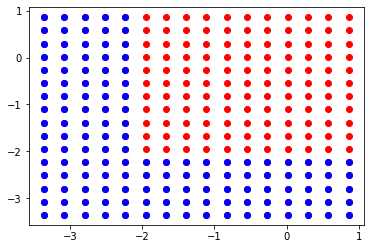

In [3]:
gr.create_tiles(null_hypos)
plt.plot(gr.thetas()[0,:], gr.thetas()[1,:], 'ro')
gr.prune()
plt.plot(gr.thetas()[0,:], gr.thetas()[1,:], 'bo')
plt.show()

Run a single example set of data and make sure that the kevlar model is producing the sample results as the prototype FastINLA code.

In [4]:
y = np.array([[4, 5]])
n = np.array([[35, 35]])
critical_values = [0.85] # final analysis exceedance requirement (note for interim analysis, the threshold)
b = model_type(
    n[0,0],
    critical_values,
    np.full(2, fi.thresh_theta),
    fi.sigma2_rule.wts.copy(),
    fi.cov.reshape((-1, 4)).T.copy(),
    fi.neg_precQ.reshape((-1, 4)).T.copy(),
    fi.logprecQdet.copy(),
    fi.log_prior.copy(),
    fi.tol,
    fi.logit_p1
)
correct = fi.numpy_inference(y, n)[1][0]
exc = b.get_posterior_exceedance_probs(y[0])
np.testing.assert_allclose(exc, correct)

In [5]:
import time
start = time.time()
out = accumulate_process(b, gr, sim_size, seed, n_threads)
end = time.time()
print('runtime', end - start)

runtime 4.151914119720459


In [7]:
theta = gr.thetas().T.copy()
# TODO: it'd be nice to add theta_tiles and is_null_per_arm to the GridRange object!
cum_n_tiles = np.array(gr.cum_n_tiles)
n_tiles_per_pt = cum_n_tiles[1:] - cum_n_tiles[:-1]
theta_tiles = np.repeat(theta, n_tiles_per_pt, axis=0)

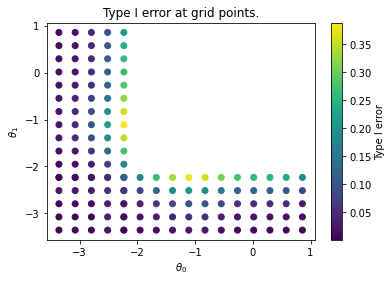

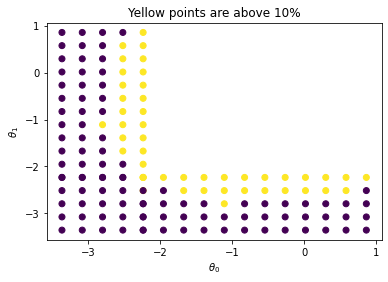

In [8]:
plt.figure()
plt.title('Type I error at grid points.')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=out.typeI_sum()[0] / sim_size)
cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()
plt.title('Yellow points are above 10%')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=out.typeI_sum()[0] / sim_size > 0.1)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.show()

# Python re-implementation of accumulation

In the cell below, I generate random numbers using exactly the same mechanism as the C++ code. THIS WOULD BE UNNECESSARY in a normal situation where I'm not trying to exactly reproduce Kevlar accumulation results.

In [9]:
%%time

# Use the mt19937 object exported from C++ so that we can match the C++ random
# sequence exactly. This is not necessary in the long term but is temporarily
# useful to ensure that this code is producing identical output to the C++
# version.
n_arm_samples = 35
gen = mt19937(seed)

# We flip the order of n_arms and n_arm_samples here so the random number
# generator produces the same sequence of uniforms as are used in the C++ kevlar
# internals. The Kevlar function operates in column-major/Fortran order. Whereas
# here, numpy operates in row-major/C ordering b
samples = np.empty((sim_size, n_arms, n_arm_samples))
gen.uniform_sample(samples.ravel())
# after transposing, samples will have shape (sim_size, n_arm_samples, n_arms)
samples = np.transpose(samples, (0, 2, 1))

CPU times: user 7.08 ms, sys: 146 µs, total: 7.23 ms
Wall time: 7.22 ms


In [10]:
# In a normal situation, we can generate samples like this:
# np.random.seed(seed)
# samples = np.random.rand(sim_size, n_arm_samples, n_arms)

In [19]:
%%time
# Calculate exceedance from each simulated sample.
# 1. Calculate the binomial count data.
# 2. See the FastINLA module for details on the inference procedure.
# 3. Success is defined by whether the exceedance probability exceeds the
#    critical value

# The sufficient statistic for binomial is just the number of uniform draws
# above the threshold probability. But the `p` array has shape (n_thetas,
# n_arms). So, we add empty dimensions to broadcast to an output `y` array of
# shape: (n_thetas, sim_size, n_arm_samples, n_arms)
theta = gr.thetas().T.copy()
# TODO: it'd be nice to add theta_tiles and is_null_per_arm to the GridRange object!
cum_n_tiles = np.array(gr.cum_n_tiles)
n_tiles_per_pt = cum_n_tiles[1:] - cum_n_tiles[:-1]
theta_tiles = np.repeat(theta, n_tiles_per_pt, axis=0)
p_tiles = expit(theta_tiles)
y = np.sum(samples[None] < p_tiles[:, None, None, :], axis=2)

# FastINLA expects inputs of shape (n, n_arms) so we must flatten our 3D arrays.
# We reshape exceedance afterwards to bring it back to 3D (n_thetas, sim_size, n_arms)
# TODO: This is where we implement the early stopping procedure.
y_flat = y.reshape((-1, 2))
n_flat = np.full_like(y_flat, n_arm_samples)
_, exceedance_flat, _, _ = fi.jax_inference(y_flat, n_flat)
exceedance = exceedance_flat.reshape(y.shape).to_py()
# instead of success, "did we reject"
success = exceedance > critical_values[0]

CPU times: user 991 ms, sys: 44.8 ms, total: 1.04 s
Wall time: 367 ms


In [20]:
%%time
# Determine type I error. 
# 1. type I is only possible when the null hypothesis is true. 
# 2. check all null hypotheses.
# 3. sum across all the simulations.
is_null_per_arm = np.array([[gr.check_null(i, j) for j in range(n_arms)] for i in range(p_tiles.shape[0])])
false_reject = success & is_null_per_arm[:, None,]
any_rejection = np.any(false_reject, axis=-1)
typeI_sum = any_rejection.sum(axis=-1)

CPU times: user 3.4 ms, sys: 1.15 ms, total: 4.54 ms
Wall time: 3.15 ms


In [21]:
%%time
# The score function is the primary component of the typeI gradient:
# 1. for binomial, it's just: y - n * p
# 2. only summed when there is a rejection in the given simulation
score = y - n_arm_samples * p_tiles[:, None, :]
typeI_score = np.sum(any_rejection[:, :, None] * score, axis=1)

CPU times: user 3.89 ms, sys: 1.37 ms, total: 5.27 ms
Wall time: 4.01 ms


Confirm that Kevlar and this Python code produce the same output.

In [24]:
typeI_good = np.all(out.typeI_sum() == typeI_sum)
score_good = np.all(np.abs(out.score_sum().reshape((-1, 2)) - typeI_score) < 1e-13)
typeI_good, score_good

(True, True)

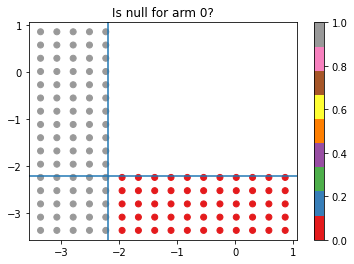

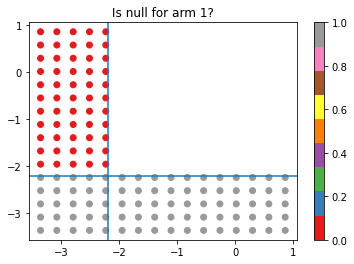

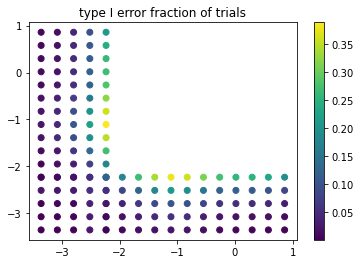

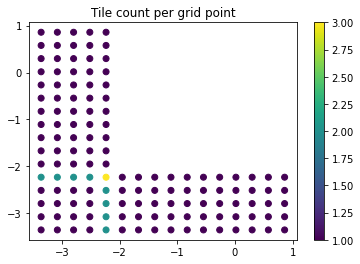

In [30]:
# y_avg = np.mean(y, axis=1)
# plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=y_avg[:,0] / n_arm_samples)
# plt.colorbar()
# plt.show()
# plt.title()
# plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=y_avg[:,1] / n_arm_samples)
# plt.colorbar()
# plt.show()
pos_start = gr.cum_n_tiles[:-1]
is_null_per_arm_gridpt = np.add.reduceat(is_null_per_arm, pos_start, axis=0) > 0

plt.title('Is null for arm 0?')
plt.scatter(theta[:,0], theta[:,1], c=is_null_per_arm_gridpt[:,0], cmap='Set1')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()
plt.title('Is null for arm 1?')
plt.scatter(theta[:,0], theta[:,1], c=is_null_per_arm_gridpt[:,1], cmap='Set1')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()

plt.title('type I error fraction of trials')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=typeI_sum / sim_size)
plt.colorbar()
plt.show()

plt.title('Tile count per grid point')
plt.scatter(theta[:,0], theta[:,1], c=n_tiles_per_pt)
plt.colorbar()
plt.show()

# Comparing against MCMC for a few grid points

This is a check to determine how much of the type I error is real versus an artifact coming from INLA.



In [15]:
import mcmc

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
sorted_idxs = np.argsort(typeI_sum)
idx = sorted_idxs[-1]
p_tiles[idx]

array([0.09670579, 0.24798743])

In [17]:
y_mcmc = y[idx, :]
n_mcmc = np.full((sim_size, n_arms), n_arm_samples)
data_mcmc = np.stack((y_mcmc, n_mcmc), axis=-1)
n_mcmc_sims = 1000
results_mcmc = mcmc.mcmc_berry(
    data_mcmc[:n_mcmc_sims], fi.logit_p1, np.full(n_mcmc_sims, fi.thresh_theta), n_arms=2
)
success_mcmc = results_mcmc["exceedance"] > critical_values[0]

In [1]:
import pickle
with open(f'berry_kevlar_mcmc{idx}.pkl', 'wb') as f:
    pickle.dump(results_mcmc, f)

NameError: name 'idx' is not defined

In [20]:
mcmc_typeI = np.sum(np.any(success_mcmc & is_null_per_arm[idx, None,:], axis=-1), axis=-1)
inla_typeI = typeI_sum[idx]
mcmc_typeI, inla_typeI

(335, 388)

In [22]:
bad_sim_idxs = np.where(
    np.any((success[idx] & (~success_mcmc)) & is_null_per_arm[idx, None], axis=-1)
)[0]
unique_bad = np.unique(y[idx, bad_sim_idxs], axis=0)
print("theta =", theta_tiles[idx])
bad_count = 0
for i in range(unique_bad.shape[0]):
    y_bad = unique_bad[i]
    other_sim_idx = np.where((y[idx, :, 0] == y_bad[0]) & (y[idx, :, 1] == y_bad[1]))[0]
    pct_mcmc = (
        np.any(
            success_mcmc[other_sim_idx] & is_null_per_arm[idx, None, :], axis=-1
        ).sum()
        / other_sim_idx.shape[0]
    )
    if pct_mcmc < 0.2:
        print("bad y =", y_bad, "count =", other_sim_idx.shape[0])
        bad_count += other_sim_idx.shape[0]
print("\ninla type I =", inla_typeI)
print("bad type I count =", bad_count)
print('"true" type I count =', inla_typeI - bad_count)
# print('pct of mcmc sims that had type I error', pct_mcmc)
# print('')

# print(
#     "unique y where INLA says type 1 but MCMC says not type 1: ",
#     np.unique(y[idx, bad_sim_idxs], axis=0),
# )


theta = [-2.234375 -1.109375]
bad y = [6 4] count = 2

inla type I = 388
bad type I count = 2
"true" type I count = 386


In [63]:
bad_sim_idxs = np.where(np.any((success[idx] & (success_mcmc)) & is_null_per_arm[idx, None], axis=-1))[0]
print('theta: ', theta_tiles[idx])
print('unique y where INLA says type 1 and MCMC also says type 1: ', np.unique(y[idx, bad_sim_idxs], axis=0))

theta:  [-2.234375 -1.109375]
unique y where INLA says type 1 and MCMC also says type 1:  [[ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 14]
 [ 5 15]
 [ 5 16]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 6 11]
 [ 6 12]
 [ 6 13]
 [ 6 15]
 [ 6 16]
 [ 6 19]
 [ 7  4]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 7  9]
 [ 7 10]
 [ 7 11]
 [ 7 12]
 [ 7 13]
 [ 7 14]
 [ 7 15]
 [ 8  3]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 8 11]
 [ 9  6]
 [ 9  9]
 [ 9 10]
 [10  7]]


In [64]:

bad_sim_idxs = np.where(np.any((~success[idx] & (~success_mcmc)) & is_null_per_arm[idx, None], axis=-1))[0]
print('theta: ', theta_tiles[idx])
print('unique y where INLA says type 1 and MCMC also says type 1: ', np.unique(y[idx, bad_sim_idxs], axis=0))

theta:  [-2.234375 -1.109375]
unique y where INLA says type 1 and MCMC also says type 1:  [[ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 2 15]
 [ 2 16]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 17]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 4 16]
 [ 5  3]
 [ 5  4]]


# Building a rejection table

In [ ]:
ys = np.arange(n_arm_samples + 1)
Ygrids = np.stack(np.meshgrid(*[ys] * fi.n_arms, indexing='ij'), axis=-1)
Ygrids.shape

(36, 36, 36, 36, 4)

In [ ]:
Yravel = Ygrids.reshape((-1, fi.n_arms))
Yravel.shape

(1679616, 4)

In [ ]:
is_sorted = np.logical_and.reduce([Yravel[:, i + 1] >= Yravel[:, i] for i in range(fi.n_arms - 1)])
is_sorted.sum() / Yravel.shape[0]

0.04897012174211248

In [ ]:
Y_sorted = Yravel[is_sorted]

In [ ]:
colsortidx = np.argsort(Yravel, axis=-1)
inverse_colsortidx = np.zeros(Yravel.shape, dtype=np.int32)
inverse_colsortidx[np.arange(Yravel.shape[0])[:, None], colsortidx] = np.arange(fi.n_arms)

In [ ]:

Y_colsorted = Yravel[np.arange(Yravel.shape[0])[:,None],colsortidx]
Y_colsorted[-10:]

array([[26, 35, 35, 35],
       [27, 35, 35, 35],
       [28, 35, 35, 35],
       [29, 35, 35, 35],
       [30, 35, 35, 35],
       [31, 35, 35, 35],
       [32, 35, 35, 35],
       [33, 35, 35, 35],
       [34, 35, 35, 35],
       [35, 35, 35, 35]])

In [ ]:
np.all(Y_colsorted[np.arange(Yravel.shape[0])[:,None],inverse_colsortidx] == Yravel)

True

In [ ]:
Y_unique, inverse_unique = np.unique(Y_colsorted, axis=0, return_inverse=True)
Y_unique.shape

(82251, 4)

In [ ]:
np.all(Y_colsorted == Y_unique[inverse_unique])

True

In [ ]:
a = 0
for i in range(36):
    for j in range(i, 36):
        for k in range(j, 36):
            for q in range(k, 36):
                a += 1
a

82251

In [ ]:
%%time
N = np.full_like(Y_unique, n_arm_samples)
reject_unique = fi.rejection_inference(Y_unique, N, method='jax')
reject = reject_unique[inverse_unique][np.arange(Yravel.shape[0])[:, None], inverse_colsortidx]

CPU times: user 2.3 s, sys: 232 ms, total: 2.53 s
Wall time: 1.28 s


In [ ]:
n_test = 100
rand_idxs = np.random.randint(0, reject.shape[0], size=(n_test,))
np.all(reject[rand_idxs] == fi.rejection_inference(Yravel[rand_idxs], np.full((n_test, 4), n_arm_samples)))

DeviceArray(True, dtype=bool)

In [ ]:
import jax.numpy as jnp
import jax
@jax.jit
def rejection_table(y, n):
    y_index = (y * (36 ** jnp.arange(4)[::-1])[None,:]).sum(axis=-1)
    return reject[y_index, :]

In [ ]:
y = np.random.randint(0, n_arm_samples + 1, size=(n_test,4))
np.all(rejection_table(y, None) == fi.rejection_inference(y, np.full((n_test, 4), n_arm_samples)))

DeviceArray(True, dtype=bool)

In [ ]:
theta_tiles = grid.theta_tiles(gr)
is_null_per_arm = grid.is_null_per_arm(gr)

In [ ]:
reject.shape

(1679616, 4)

In [ ]:
def fnc(x):
    return x + 1

In [ ]:
import multiprocessing as mp
mp_start_count = 0

if __name__ == '__main__':
    if mp_start_count == 0:
        try:
            mp.set_start_method('fork')
        except RuntimeError:
            # This error happens when the cell is run a second time because the
            # start method cannot be changed after the multiprocessing context
            # has already been set.
            pass
        mp_start_count += 1
    p = mp.Pool(2)
    print(p.map(fnc, range(2)))

Process ForkServerPoolWorker-1:
Traceback (most recent call last):
  File "/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'fnc' on <module '__main__' (built-in)>
Process ForkServerPoolWorker-2:
Traceback (most recent call last):
  File "/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._

KeyboardInterrupt: 

In [ ]:
def chunk_accum(seed, chunk_size):
    np.random.seed(seed)
    typeI_sum = np.zeros(theta_tiles.shape[0])
    typeI_score = np.zeros(theta_tiles.shape)
    accumulator = binomial_accumulator(rejection_table)
    for i in range(1):
        samples = np.random.uniform(0, 1, size=(1, n_arm_samples, fi.n_arms))
        chunk_typeI_sum, chunk_typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)
        typeI_sum += chunk_typeI_sum
        typeI_score += chunk_typeI_score
    return typeI_sum, typeI_score

In [ ]:
n_cores = 1
# Split sim_size
chunk_size = int(np.floor(sim_size / n_cores))
chunk_sizes = np.full(n_cores, chunk_size)
# Spread the remainder over the chunks.
for i in range(sim_size - (chunk_size * n_cores)):
    chunk_sizes[i] += 1
print(chunk_sizes)
import multiprocessing
p = multiprocessing.Pool(n_cores)
seeds = 10 + np.arange(n_cores)
p.starmap(chunk_accum, zip(seeds, chunk_sizes))

[1000]
a
b
c
d
e
f


KeyboardInterrupt: 

In [ ]:
%%time
np.random.seed(10)
typeI_sum = np.zeros(theta_tiles.shape[0])
typeI_score = np.zeros(theta_tiles.shape)
accumulator = binomial_accumulator(rejection_table)
for i in range(sim_size):
    samples = np.random.uniform(0, 1, size=(1, n_arm_samples, fi.n_arms))
    chunk_typeI_sum, chunk_typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)
    typeI_sum += chunk_typeI_sum
    typeI_score += chunk_typeI_score

CPU times: user 19.1 s, sys: 15.1 s, total: 34.3 s
Wall time: 11.1 s


In [ ]:
typeI_sum.shape, theta_tiles.shape

((143856,), (143856, 4))

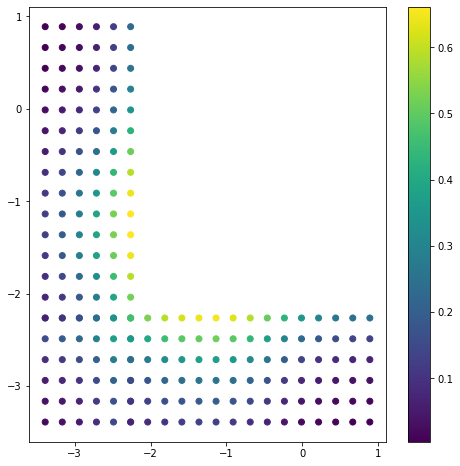

In [ ]:
slice2 = (-1.2, -1)
slice3 = (-1.2, -1)
# slice2 = (-3, -2.5)
# slice3 = (-3, -2.5)
selection = (
    (theta_tiles[:,2] > slice2[0]) & (theta_tiles[:,2] < slice2[1])
    & (theta_tiles[:,3] > slice3[0]) & (theta_tiles[:,3] < slice3[1])
)
plt.figure(figsize=(8,8))
plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=typeI_sum[selection]/sim_size)
plt.colorbar()
plt.show()

# Running a 4D grid

In [1]:
import os

# NOTE: don't be surprised if this JAX code does not scale linearly.
# JAX already uses parallelism within a single CPU device, so using multiple CPU
# devices will only take advantage of the remaining unused cores. In addition,
# there will be thrashing between the different threads trying to claim the same
# cores. This could be fixed by CPU pinning the JAX threads. There might be more
# potential to do this with a multiprocessing-based version of this
# parallelization. However, I didn't do this at the moment because I'm working
# on Mac where there is are no easy tools for CPU pinning threads. In addition, for
# higher performance, we should really be running this on a GPU where the effort
# of setting up tools for CPU pinning will have been wasted.
# see: https://github.com/google/jax/issues/743
# some other links that might be useful for parallel and multiprocessing JAX:
# - this link provides a path to cpu pinning on mac: http://www.hybridkernel.com/2015/01/18/binding_threads_to_cores_osx.html
# - more info on JAX multithreading: https://github.com/google/jax/issues/1539
# - running JAX inside multiprocessing: https://github.com/google/jax/issues/1805
n_requested_cores = 8
os.environ["XLA_FLAGS"] = (
    f"--xla_force_host_platform_device_count={n_requested_cores} "
    "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import numpy as np
from pykevlar import mt19937
import pykevlar.grid as grid
from pykevlar.driver import accumulate_process
import pykevlar.core.model.binomial
import binomial

import util
import fast_inla

name = 'berry2'
fi = fast_inla.FastINLA(4)
seed = 10
n_arm_samples = 35
n_theta_1d = 64
sim_size = 10000

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
loaded = np.load(f"{name}_{n_theta_1d}_{sim_size}.npy", allow_pickle=True).tolist()
gr = loaded['gr']
typeI_sum = loaded["sum"]
typeI_score = loaded["score"]
table = loaded["table"]
theta_tiles = loaded["theta_tiles"]
is_null_per_arm = loaded["is_null_per_arm"]

FileNotFoundError: [Errno 2] No such file or directory: 'berry2_64_10000.npy'

In [3]:
%%time
# define null hypos
null_hypos = []
for i in range(fi.n_arms):
    n = np.zeros(fi.n_arms)
    # null is:
    # theta_i <= logit(0.1)
    # the normal should point towards the negative direction. but that also
    # means we need to negate the logit(0.1) offset
    n[i] = -1
    null_hypos.append(grid.HyperPlane(n, -logit(0.1)))

gr = grid.make_cartesian_grid_range(n_theta_1d, np.full(fi.n_arms, -3.5), np.full(fi.n_arms, 1.0), sim_size)
gr.create_tiles(null_hypos)
gr.prune()
theta_tiles = grid.theta_tiles(gr)
is_null_per_arm = grid.is_null_per_arm(gr)

CPU times: user 31min 7s, sys: 8.27 s, total: 31min 15s
Wall time: 31min 16s


In [4]:
%%time
table = binomial.build_rejection_table(fi.n_arms, n_arm_samples, fi.rejection_inference)

CPU times: user 4.3 s, sys: 189 ms, total: 4.49 s
Wall time: 3.35 s


# Parallel Jax accumulation

In [5]:
import time
import jax
import jax.numpy as jnp

reject_fnc = lambda y, n: binomial.lookup_rejection(table, y, n)
accum = binomial.binomial_accumulator(reject_fnc)
paccum = jax.pmap(accum, in_axes=(None, None, 0), out_axes=(0, 0), axis_name='i')
# paccum = jax.pmap(accum, in_axes=(None, None, 0), out_axes=(None, None), axis_name='i')

In [6]:
%%time
np.random.seed(seed)
typeI_sum = np.zeros(theta_tiles.shape[0], dtype=np.uint32)
typeI_score = np.zeros(theta_tiles.shape)
n_cores = jax.local_device_count()
for i in range(int(np.ceil(sim_size / n_cores))):
    chunk_size = np.minimum(n_cores, sim_size - i * n_cores)
    samples = np.random.uniform(0, 1, size=(chunk_size, 1, n_arm_samples, fi.n_arms))
    s, c = paccum(theta_tiles, is_null_per_arm, samples)
    typeI_sum += s.sum(axis=0)
    typeI_score += c.sum(axis=0)

KeyboardInterrupt: 

In [9]:
i * n_cores, sim_size

(8160, 10000)

In [11]:
sim_size = 8160

In [12]:
np.save(
    f"{name}_{n_theta_1d}_{sim_size}.npy",
    dict(
        sum=typeI_sum,
        score=typeI_score,
        gr=gr,
        table=table,
        theta_tiles=theta_tiles,
        is_null_per_arm=is_null_per_arm,
    ),
    allow_pickle=True,
)


# A multiprocessing parallel version.

In [10]:
import time
def chunk_accum(seed, chunk_size):
    start = time.time()
    reject_fnc = lambda y, n: binomial.lookup_rejection(table, y, n)
    np.random.seed(seed)
    typeI_sum = np.zeros(theta_tiles.shape[0])
    typeI_score = np.zeros(theta_tiles.shape)
    print(time.time() - start)
    start = time.time()
    accumulator = binomial.binomial_accumulator(reject_fnc)
    print(time.time() - start)
    start = time.time()
    for i in range(chunk_size):
        samples = np.random.uniform(0, 1, size=(1, n_arm_samples, fi.n_arms))
        chunk_typeI_sum, chunk_typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)
        typeI_sum += chunk_typeI_sum
        typeI_score += chunk_typeI_score
    print(time.time() - start)
    start = time.time()
    return typeI_sum, typeI_score

In [11]:
import cloudpickle

In [14]:
%%time
n_cores = 8
# Split sim_size
chunk_size = int(np.floor(sim_size / n_cores))
chunk_sizes = np.full(n_cores, chunk_size)
# Spread the remainder over the chunks.
for i in range(sim_size - (chunk_size * n_cores)):
    chunk_sizes[i] += 1
print(chunk_sizes)
import multiprocessing
p = multiprocessing.Pool(n_cores)
seeds = 10 + np.arange(n_cores)
fnc_pkl = [cloudpickle.dumps(chunk_accum)] * len(seeds)
args = list(zip(fnc_pkl, seeds, chunk_sizes))

[125 125 125 125 125 125 125 125]
CPU times: user 10.8 ms, sys: 58.3 ms, total: 69.1 ms
Wall time: 80.7 ms


In [15]:
%%time
results = p.starmap(binomial.cloudpickle_helper, args)
# results = []
# for i in range(n_cores):
#     print(i)
#     results.append(chunk_accum(*list(args)[i][1:]))

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbe

0.00017786026000976562
2.7894973754882812e-05
0.0002841949462890625
3.0994415283203125e-05
0.00018405914306640625
4.410743713378906e-05
0.00017189979553222656
2.5033950805664062e-05
0.0002532005310058594
0.00012087821960449219
0.00017690658569335938
3.1948089599609375e-05
0.0001697540283203125
3.0279159545898438e-05
0.0001690387725830078
2.5987625122070312e-05


1.2893309593200684
1.2718281745910645
1.3132221698760986
1.3462581634521484
1.3955283164978027
1.3987150192260742
1.6197519302368164
1.5989320278167725
CPU times: user 21 ms, sys: 42.7 ms, total: 63.7 ms
Wall time: 2.68 s


# Making some figures!

In [13]:
%config InlineBackend.figure_format='retina'
factor = 0.75
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
plt.rcParams["font.size"] = 20 * factor
plt.rcParams["axes.labelsize"] = 18 * factor
plt.rcParams["axes.titlesize"] = 20 * factor
plt.rcParams["xtick.labelsize"] = 16 * factor
plt.rcParams["ytick.labelsize"] = 16 * factor
plt.rcParams["legend.fontsize"] = 20 * factor
plt.rcParams["figure.titlesize"] = 22 * factor
plt.rcParams["axes.facecolor"] = (1.0, 1.0, 1.0, 1.0)
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 1.0)
plt.rcParams["savefig.transparent"] = False
plt.rcParams["image.cmap"] = "plasma"

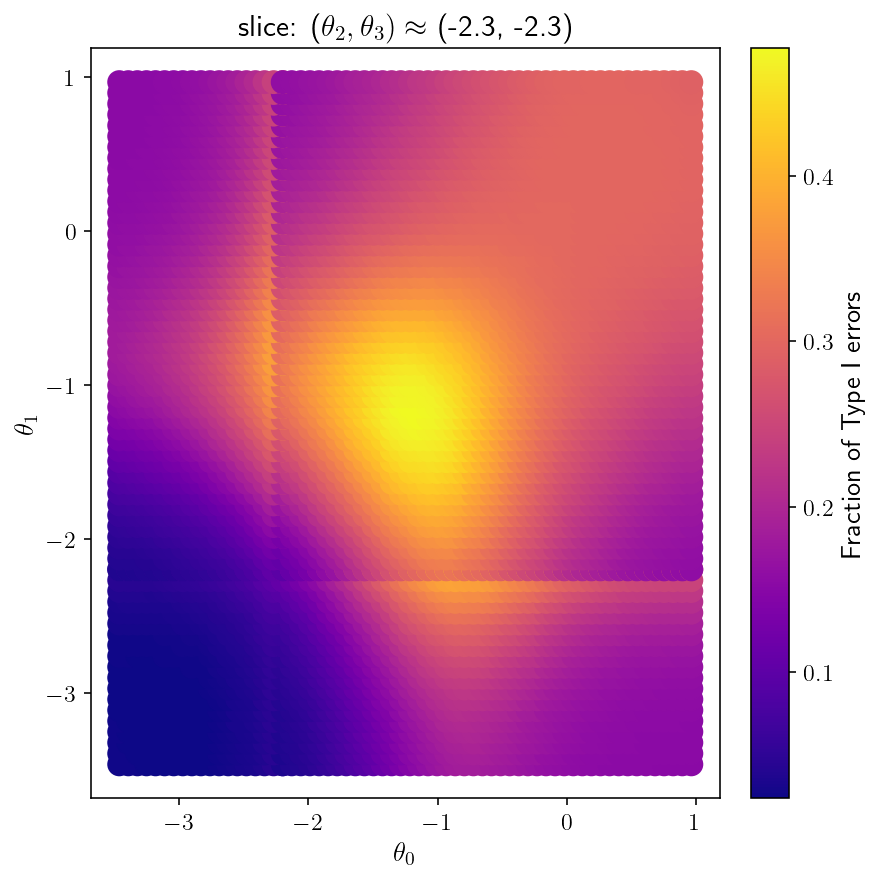

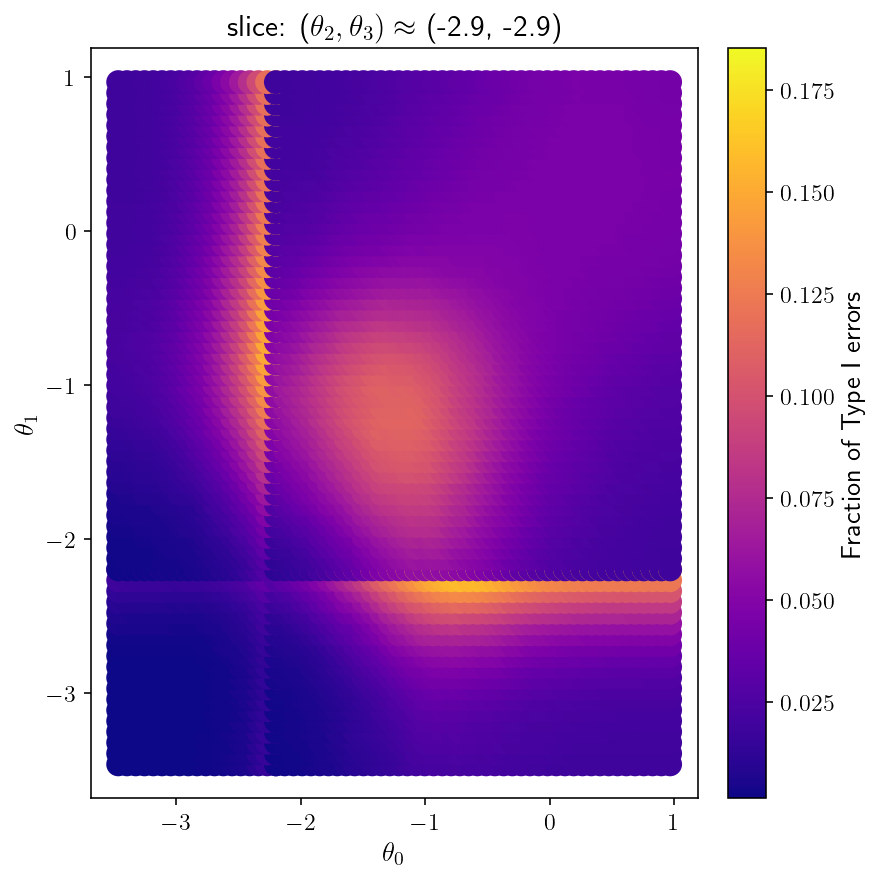

In [14]:
# slice2 = (-1.2, -1.1)
# slice3 = (-1.2, -1.1)
for t2_idx, t3_idx in [(16, 16), (8, 8)]:
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    t3 = np.unique(theta_tiles[:, 2])[t3_idx]
    selection = (theta_tiles[:,2] == t2) & (theta_tiles[:,3] == t3)

    plt.figure(figsize=(6,6), constrained_layout=True)
    plt.title(f'slice: ($\\theta_2, \\theta_3) \\approx$ ({t2:.1f}, {t3:.1f})')
    plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=typeI_sum[selection]/sim_size, s=120)
    cbar = plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    cbar.set_label('Fraction of Type I errors')
    plt.savefig(f'grid_type1_{t2_idx}_{t3_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
from pykevlar.model.binomial import SimpleSelection
sys.path.append('../')
import utils
delta = 0.025
simple_selection_model = SimpleSelection(fi.n_arms, n_arm_samples, 1, [])
simple_selection_model.critical_values([fi.critical_value])

In [24]:
gr.sim_sizes()[:] = sim_size

In [25]:
from pykevlar.bound import TypeIErrorAccum
acc_o = TypeIErrorAccum(simple_selection_model.n_models(), gr.n_tiles(), gr.n_params())
typeI_sum = typeI_sum.astype(np.uint32).reshape((1, -1))
score_sum = typeI_score.flatten()
acc_o.pool_raw(typeI_sum, score_sum)
print(np.all(acc_o.typeI_sum() == typeI_sum))
print(np.all(acc_o.score_sum() == score_sum))

True
True


In [26]:
P, B = utils.create_ub_plot_inputs(simple_selection_model, acc_o, gr, delta)

In [27]:
n_theta_1d

64

In [ ]:
np.save(
    f"{name}_{n_theta_1d}_{sim_size}.npy",
    dict(
        P=P,
        B=B,
        sum=typeI_sum,
        score=typeI_score,
        gr=gr,
        table=table,
        theta_tiles=theta_tiles,
        is_null_per_arm=is_null_per_arm,
    ),
    allow_pickle=True,
)

In [29]:

for t2_idx, t3_idx in [(40, 40), (32, 32), (24, 24), (16, 16), (8, 8)]:
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    t3 = np.unique(theta_tiles[:, 2])[t3_idx]
    selection = (theta_tiles[:,2] == t2) & (theta_tiles[:,3] == t3)
    Pselect = P[:, selection]
    Bselect = B[selection, :]
    utils.save_ub(f"P-{name}-{n_theta_1d}-{sim_size}-{t2_idx}.csv", f"B-{name}-{n_theta_1d}-{sim_size}-{t3_idx}.csv", Pselect, Bselect)